## Imports and preamble

These are external libraries, including your own code stored in separate .py files, that you want to import in order to run the notebook. Since our notebook environment is running in Python, we don't need to import the language itself.

 However, it's worth checking that you are using the right version of Python (usually Python 3)

 For larger projects, you will want to use separate virtual environments for different projects. It's a good idea to double check your environment

In [9]:
# pre-installed library containing a grab bag of system functions
import sys
print(sys.version)

# Import some local code, which I'll use behind the scenes
# from ../resources import helper_functions

# Wipe all outputs from this notebook
from IPython.display import Image, clear_output
clear_output(True)

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np


3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:41:52) [Clang 15.0.7 ]


# Python Functions and Ornstein-Uhlenbeck processes

+ keyword arguments are optional arguments with default values
+ variables within functions alwayus have local scope
+ docstrings should document all arguments and returns

Here we are going to implement a function that computes the next step of an Ornstein-Uhlenbeck process, which describes the motion of a particle in a harmonic potential with noise

$$
dx_{t}=-\alpha \,x_{t}\,dt+\sigma \,dW_{t}
$$

In discrete time, this becomes

$$
x_{t+1}=x_{t}-\alpha \,x_{t}\,\Delta t+\sigma \,\sqrt{\Delta t}\,Z_{t}
$$

where $Z_{t}$ is a standard normal random variable. For simplicity, hereafter we will assume that time in measured in units for which $\delta t=1$, thus making the two terms in the discrete process separately proportional to the simulation parameters $\alpha$ and $\sigma$.

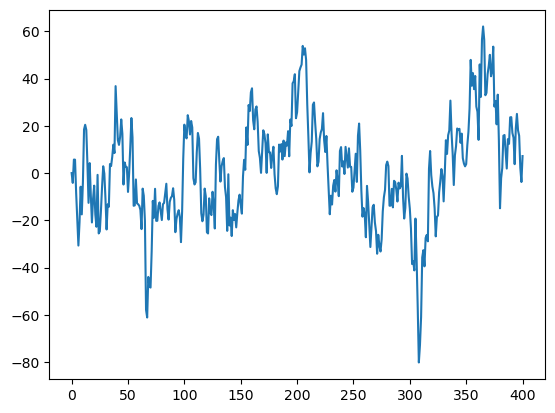

In [3]:
import random
import math

def ornstein_uhlenbeck_process(x, alpha=0.1, sigma=1.0):
    """
    One step for the dynamics of a particle in a harmonic potential, with Brownian noise

    Equivalent to an AR(1) process with alpha = 1
    """
    # forcing term
    drift = -alpha * x # forcing term

    # stochastic diffusion term
    diffusion = sigma * random.gauss(0, 1)

    x_nxt = x + drift + diffusion
    return x_nxt

# for short functions, we might sometime use a lambda function
ornstein_uhlenbeck_process = lambda x, alpha, sigma=1.0: x -alpha * x + sigma * random.gauss(0, 1)

all_steps = [0]
for i in range(400):
    all_steps.append(ornstein_uhlenbeck_process(all_steps[-1], sigma=10, alpha=0.1))
plt.figure()
plt.plot(all_steps)

# all_steps = [0]
# for i in range(400):
#     all_steps.append(ornstein_uhlenbeck_process(all_steps[-1], 0*0.1))
# plt.figure()
# plt.plot(all_steps)


# all_steps = [0]
# for i in range(400):
#     all_steps.append(ornstein_uhlenbeck_process(all_steps[-1], 0.1, sigma=10))
# plt.figure()
# plt.plot(all_steps)

In [4]:
print(drift) # this will fail because drift is not defined outside of the function

NameError: name 'drift' is not defined

Text(0, 0.5, 'Position')

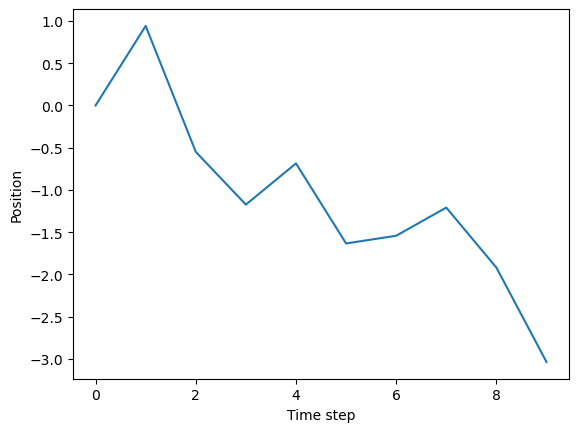

In [43]:
# While loops halt on condition, rather than number of iterations. Here, it's useful
# for finding first-passage times of the diffusion process

import random

# set pseudorandom seed
random.seed(0)

all_steps = [0]
while np.abs(all_steps[-1]) < 3:
    all_steps.append(ornstein_uhlenbeck_process(all_steps[-1], 0.1))

plt.figure()
plt.plot(np.arange(len(all_steps)), all_steps)
plt.xlabel('Time step')
plt.ylabel('Position')

### First passage time distributions

Now we will simulate a bunch of processes in order to observe the first passage time distribution.
In physics, the [first-passage time distribution](https://arxiv.org/abs/2201.10048) is the probability distribution of the times it takes for a stochastic process to first reach a certain value. 

An example where first passage time distributions are useful is in the study of chemical reactions. Oftentimes, reactants must first reach a certain energy threshold before they can react. The distribution of times it takes for the reactants to reach this threshold is the first passage time.

Text(0, 0.5, 'Count')

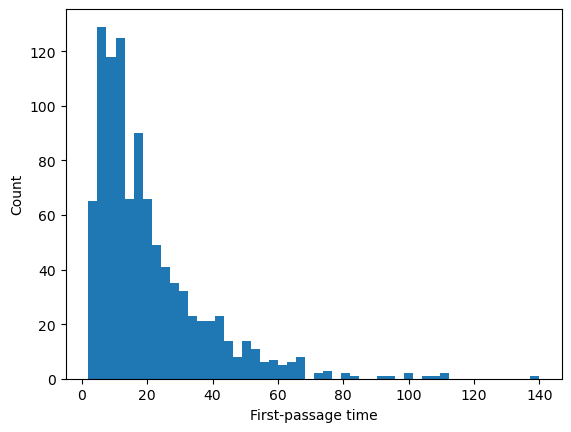

In [44]:
## now run a simulation with many trajectories to get the distribution of first-passage times
all_fpt_durations = []
for i in range(1000):
    all_steps = [0]
    while np.abs(all_steps[-1]) < 3:
        all_steps.append(ornstein_uhlenbeck_process(all_steps[-1], 0.1))

    all_fpt_durations.append(len(all_steps))

plt.figure()
plt.hist(all_fpt_durations, bins=50);
plt.xlabel('First-passage time')
plt.ylabel('Count')

## Python functions are objects

+ You can pass Python functions to other functions, as if they were any other variable. 

+ Below, we'll use lambda functions to define two versions of an Ornstein-Uhlenbeck process with different stiffnesses, as well as a Weiner process (no confinement) and random jumps



In [ ]:
# Define several stochastic processes with constant variance 1.0 and varying stiffness
ornstein_uhlenbeck_process_wide = lambda x: x - 0.05 * x + random.gauss(0, 1)
ornstein_uhlenbeck_process_tight = lambda x: x - 0.5 * x + random.gauss(0, 1)
wiener_process = lambda x: x + random.gauss(0, 1)
random_walk = lambda x: random.gauss(0, 1)

Next, we will define a function that will take a given stochastic process and return the first passage time distribution.

In [7]:

def first_passage_time(process, n_sim=10000, xc=3):
    """
    Given a random process, perform n_sim simulations and return the durations

    Args:
        process (function): a function that takes a single argument and returns a single value
        n_sim (int): number of simulations to run
        xc (float): the crossing threshold for the first passage time

    Returns:
        list: durations of the first passage times
    """
    all_fpt_durations = []
    for i in range(n_sim):
        all_steps = [0]
        while np.abs(all_steps[-1]) < xc:
            all_steps.append(process(all_steps[-1]))

        all_fpt_durations.append(len(all_steps))

    return all_fpt_durations

help(first_passage_time)


Help on function first_passage_time in module __main__:

first_passage_time(process, n_sim=10000)
    Given a random process, perform n_sim simulations and return the durations
    
    Args:
        process (function): a function that takes a single argument and returns a single value
        n_sim (int): number of simulations to run
    
    Returns:
        list: durations of the first passage times



We will now use this function to calculate the first passage time distribution for a stiff and wide Ornstein-Uhlenbeck processes.

Text(0.5, 1.0, 'Wiener process')

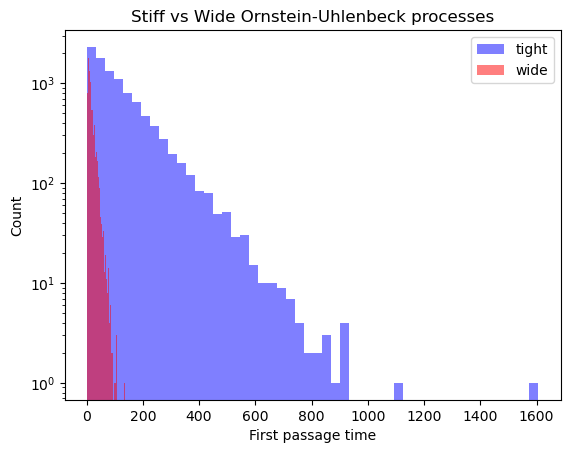

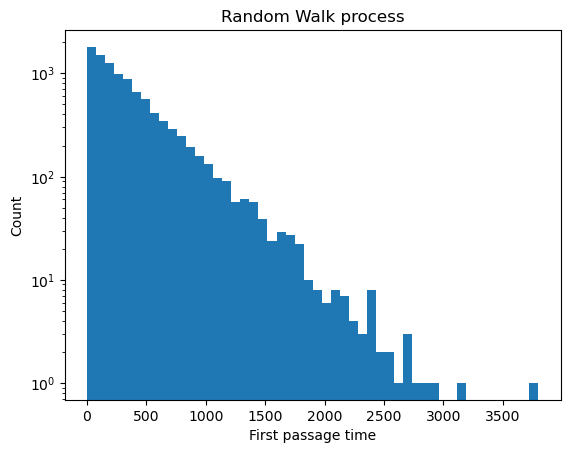

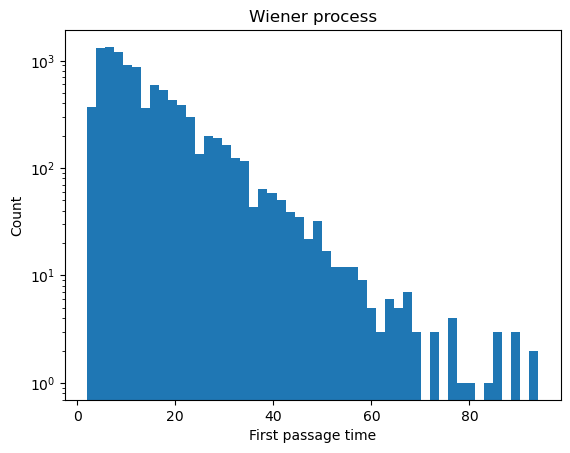

In [117]:
# Generate the first passage time distributions
fpt_times_tight = first_passage_time(ornstein_uhlenbeck_process_tight)
fpt_times_wide = first_passage_time(ornstein_uhlenbeck_process_wide)

plt.figure()
plt.semilogy()
plt.hist(fpt_times_tight, bins=50, alpha=0.5, label='tight', color='b')
plt.hist(fpt_times_wide, bins=50, alpha=0.5, label="wide", color='r')
plt.legend()
plt.title("Stiff vs Wide Ornstein-Uhlenbeck processes")
plt.xlabel("First passage time")
plt.ylabel("Count")




plt.figure()
plt.semilogy()
plt.hist(first_passage_time(random_walk), bins=50);
plt.xlabel("First passage time")
plt.ylabel("Count")
plt.title("Random Walk process")

plt.figure()
plt.semilogy()
plt.hist(first_passage_time(wiener_process), bins=50);
plt.xlabel("First passage time")
plt.ylabel("Count")
plt.title("Wiener process")

### Questions

+ Why does the more strongly-confined process have a wider first passage time distribution?

## What is the simulation showing?

The first-passage time distribution of an Ornstein-Uhlenbeck process is 
[difficult to compute analytically](https://doi.org/10.1088/1751-8121/ab0836), but our simulations suggest that it exhibits a predominantly exponential decay at long times. We can use our results to motivate an analytical approximation for the first-passage time distribution.


We first define the Ornstein-Uhlenbeck process symbolically. We define the drift term to be negative, so the process is mean-reverting.

$$
dx_{t}=-\alpha \,x_{t}\,dt+\sigma \,dW_{t}
$$

We are using the [Ito](https://en.wikipedia.org/wiki/It%C3%B4_calculus) interpretation of the stochastic differential equation. Notice how when $dW_t$ is zero, we recover a familiar ordinary differential equation. We use this notation because the stochastic term itself cannot be differentiated.

The solution to this equation is:
$$
x_{t}=x_{0}\,e^{-\alpha t} + \sigma \int_{0}^{t}e^{-\alpha (t-s)}\,dW_{s}
$$

We can next define a first-passage time function on this interval:

$$
\tau = \inf \{t>0: x_{t} \geq x_c\}
$$

where $x_c$ is the crossing threshold. We next use the Fokker-Planck equation to find the probability density function for $x_{t}$:

$$
\frac{\partial}{\partial t}p(x, t) = \alpha \frac{\partial}{\partial x} \left(x \, p(x, t) \right) + \frac{1}{2}\sigma^{2}  \frac{\partial^{2}}{\partial x^{2}}p(x, t)
$$

Unlike the single-particle stochastic process, the Fokker-Planck equation describes the *distribution* of trajectories under the process over time. In order to solve this partial differential equation, we need to learn more about how ensembles of trajectories from our process behave.



Text(0, 0.5, 'Count')

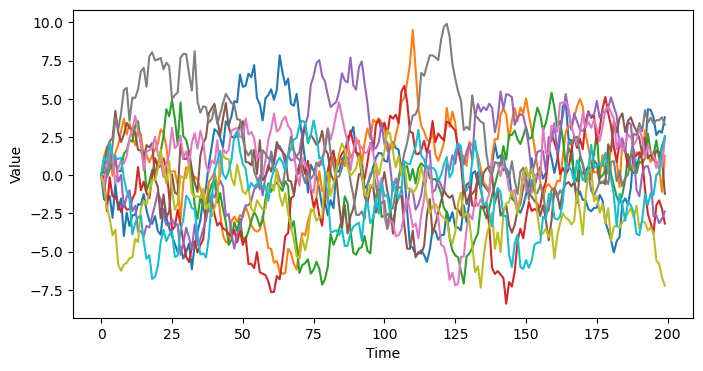

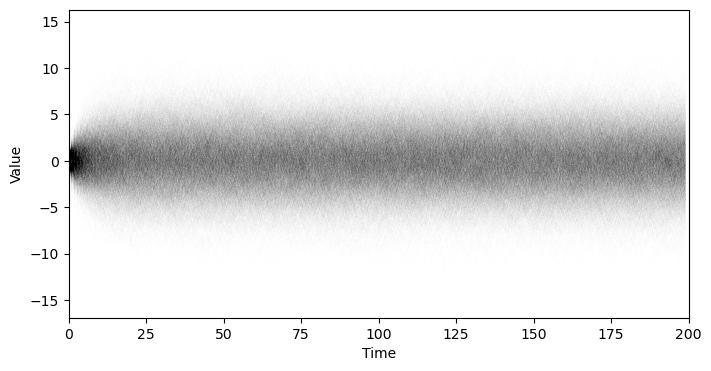

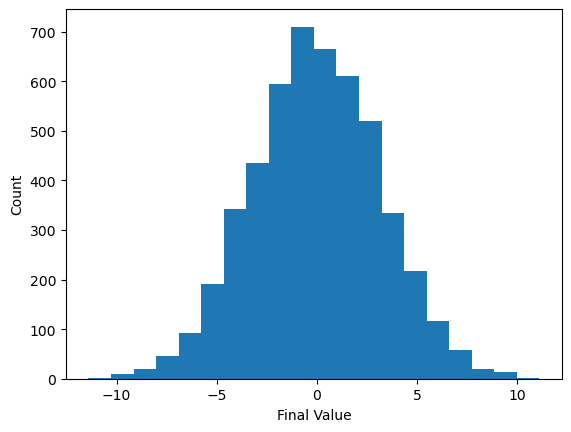

In [71]:
def run_simulation(process, n_sim, n_tpts):
    """
    A function that runs a given stochastic process n_sim times, and returns an 
    array of the results. The process is assumed to be a function that takes a
    single argument (the current value of the process) and returns the next
    value of the process.

    Args:
        process (function): A function that takes a single argument (the current
            value of the process) and returns the next value of the process.
        n_sim (int): The number of simulations to run.
        n_tpts (int): The number of time points to simulate.

    Returns:
        all_simulations (np.ndarray): An array of shape (n_sim, n_tpts) containing
            the results of the simulations. The first axis indexes the simulation
            replicate, and the second axis indexes the time point.
    """

    # Since we know the size of our output in advance, we can pre-allocate the 
    # solution array to avoid the overhead of adding elements to a list
    all_simulations = np.zeros((n_sim, n_tpts))

    for i in range(n_sim):
        for j in range(1, n_tpts):
            all_simulations[i, j] = process(all_simulations[i, j - 1])
    
    return all_simulations



out = run_simulation(ornstein_uhlenbeck_process_wide, 10, 200)
plt.figure(figsize=(8, 4))
plt.plot(out.T);
plt.xlabel('Time')
plt.ylabel('Value')


out = run_simulation(ornstein_uhlenbeck_process_wide, 5000, 200)
plt.figure(figsize=(8, 4))
plt.plot(out.T, color='k', alpha=0.005, linewidth=0.5);
plt.xlim(0, out.shape[1])
plt.xlabel('Time')
plt.ylabel('Value')

plt.figure()
plt.hist(out[:, -1], bins=20);
plt.xlabel('Final Value')
plt.ylabel('Count')




It looks like the long-time limit of the process is a Gaussian distribution. We can therefore solve the Fokker-Planck equation by imposing the analytical ansatz,
$$
p(x, t) = \frac{1}{\sqrt{2\pi \Sigma^2(t)}} \exp \left(-\frac{x^2}{2\,\Sigma^2(t)} \right)
$$
We next insert this ansatz into the Fokker-Planck equation with an initial condition given by $p(x,0) = \delta(x)$, because all of our simulations start at the origin.

Simplification of the resulting expression produces an ordinary differential equation for $\Sigma(t)$:
$$
\frac{d\Sigma(t)}{dt} = \sigma^2 + 2\alpha \Sigma(t)
$$

We impose the initial condition $\Sigma(0) = 0$ to find the solution. To avoid singularities, this can be accomplished by setting $\Sigma(0) = \epsilon$, solving the initial value problem, and then taking the limit $\epsilon \rightarrow 0$, we arrive at the expression for $\Sigma(t)$:

$$
\Sigma^2(t) = \dfrac{\sigma^2}{2\alpha} \left( 1 - e^{-2\alpha t} \right)
$$

We can see that over a timescale $\tau = 1/(2 \alpha)$, the variance of the distribution reaches an asymptotic value of $\tilde\Sigma^2 = \sigma^2/(2\alpha)$. For our tight and wide simulations, $\tau = 1^2 / (2 \cdot 0.5) = 1$ and $\tau = 1^2 / (2 \cdot 0.05) = 10$, respectively, confirming that our first passage distributions involve timescales beyond the asymptotic limit of the variance. We refer to the stationary Gaussian distribution as $\tilde p(x)$ to distinguish it from the transient time-dependent distribution $p(x,t)$.

In the asymptotic limit, we can think of the Ornstein-Uhlenbeck process as continuously sampling values from a stationary Gaussian distribution. The probability of success of a given draw is given by the fraction of the distribution that lies above the threshold at $x_c$ at any given time, which is given by $\int_{x_c}^{\infty} \tilde p(x) \, dx$. In discrete time, if we assume each draw is independent, then the probability of success after $n$ draws is given by the binomial distribution. In continuous time, this process asymptotically approaches an exponential distribution.

## Questions

1. What is the probability of success after $n$ draws from a Gaussian distribution with mean $0$ and variance $\sigma^2$?

2. Taking the continuous-time limit, what is the probability of success after a time $\tau$?

3. Given the expression for the variance of the Ornstein-Uhlenbeck process described above, what is the probability density function for the first-hitting time $\tau$?




<!-- $$
P(\tau \leq t) = \int_{x_c}^{\infty} p(x,t) \, dx = \dfrac12 \text{Erfc}\left(\dfrac{x_c}{\sqrt{2}\; \Sigma(t)}\right)
$$

From this we can calculate the probability density function for the first-hitting time,

$$
p(\tau = t) = \frac{d}{dt}P(\tau \leq t) 
$$
$$
p(\tau = t) = p(x_c, t) x_c \dot \Sigma(t)
$$
we insert our expression for $\Sigma(t)$ and find
$$
p(\tau = t) = p(x_c, t) x_c \sigma^2 e^{-2 \alpha t}
$$

Thus demonstrating the origin of the long-time exponential term in our observed first passage distribution. 

We note that some additional subtlety arises from the time dependence of $p(x_c, t)$. A more rigorous derivation requires defining the variable $\epsilon = e^{-2\alpha t}$ and expanding the full expression for $p(\tau = t)$ in powers of $\epsilon$ near $0$. The leading-order linear term describes the long-timescale exponential tail behavior of the first-passage time distribution. More accurate expressions for the first-passage time distribution [can be derived](https://doi.org/10.2307/3213779), and they are often best-expressed in Laplace transform space due to their mixed exponential decay. -->

Text(0, 0.5, 'Count')

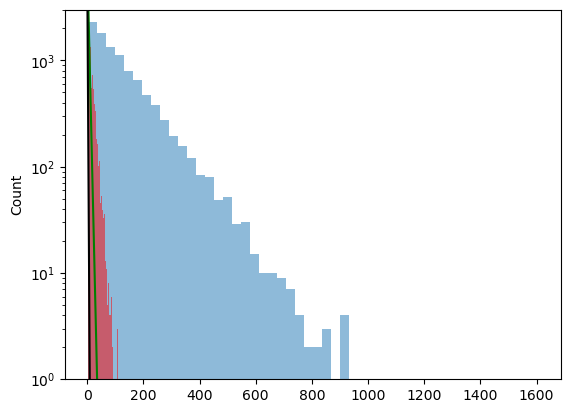

In [161]:



tvals = np.arange(0, 1000)

plt.figure()
plt.semilogy()
plt.hist(fpt_times_tight, bins=50, alpha=0.5) # 0.5
plt.hist(fpt_times_wide, bins=50, alpha=0.5, color='r') # 0.05

# plt.semilogy(10000 * np.exp(-2 * 0.004 * tvals), 'k')
# plt.semilogy(10000 * np.exp(-2 * 0.05 * tvals), 'k')
plt.semilogy(10000 * np.exp(-0.259398 * tvals), 'g')
plt.semilogy(10000 * np.exp(-1 * tvals), 'k')
plt.ylim(1, 3000)
# plt.xlim(0, 100)


# plt.figure()
# plt.semilogy()
# plt.hist(fpt_times_tight, bins=50, alpha=0.5)
# plt.hist(fpt_times_wide, bins=50, alpha=0.5, color='r')
# plt.legend()
# plt.title("Stiff vs Wide Ornstein-Uhlenbeck processes")
# plt.xlabel("First passage time")
plt.ylabel("Count")

## Classes and object-oriented programming

+ Classes are abstract Python objects that bundle variables and functions, which are usually called "methods" in this context
+ Critical for writing high-level abstract code
+ Classes are useful for keeping track of the state of a simulation
+ All classes have constructor methods, where Python reserves space for the object and sets the initial values of variables bound to the class, which are called "instance variables" in this context

Text(0, 0.5, 'Position')

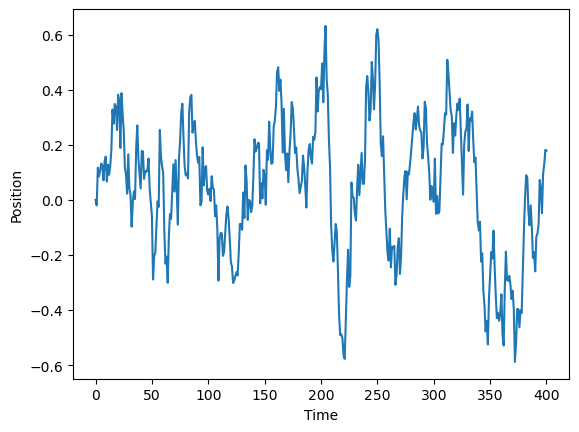

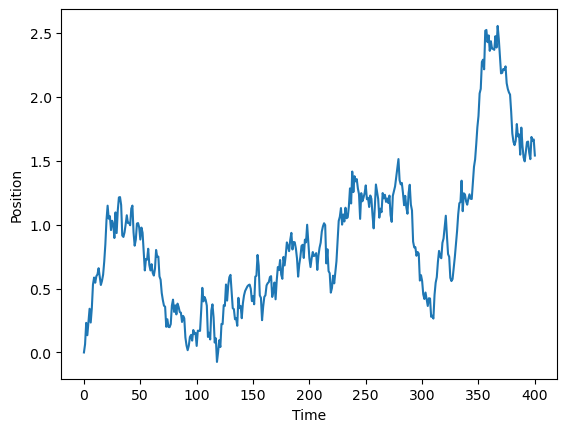

In [170]:
import random
class OrnsteinUhlenbeckProcess:
    """
    A class for generating Ornstein-Uhlenbeck processes.
    """
    # Constructor (mandatory for isolated class)
    def __init__(self, alpha, sigma):
        self.alpha = alpha
        self.sigma = sigma

    def step(self, x):
        drift = -self.alpha * x
        diffusion = self.sigma * random.gauss(0, 1)
        return x + drift + diffusion

    def run_process(self, n_steps):
        all_steps = [0]
        for i in range(n_steps):
            all_steps.append(self.step(all_steps[-1]))
        return all_steps

    ## double underscore methods are special methods to python
    def __call__(self, x):
        return self.step(x)

process1 = OrnsteinUhlenbeckProcess(.1, 0.1)
traj = process1.run_process(400)
# traj = process1(400) # use the special "call" method

plt.figure()
plt.plot(traj)
plt.xlabel("Time")
plt.ylabel("Position")



process2 = OrnsteinUhlenbeckProcess(0.001, 0.1)
traj = process2.run_process(400)
# traj = process2(400) # use the special "call" method
plt.xlabel("Time")
plt.ylabel("Position")

plt.figure()
plt.plot(traj)
plt.xlabel("Time")
plt.ylabel("Position")

# Inheritance

+ Allows you to recycle code by defining abstract classes, then specific refinements

Hierarchical inheritance (most common)
+ Multiple child classes inherit shared methods from a parent class

Multiple inheritance (common in machine learning)
+ Child merges methods from a shared parent

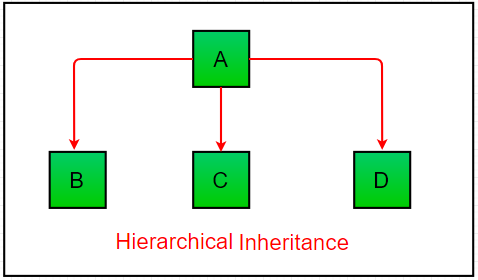

In [171]:
Image("../resources/inheritance_tree.png")
# Source: https://www.geeksforgeeks.org/types-of-inheritance-python/

Let's see an example of a generic stochastic process class, and then define some specific types of stochastic processes as subclasses of this generic class.

In discrete time, a generic AR(1) (autoregressive, order 1) stochastic process is defined as

$$
X_{t} = f(X_{t-1})
$$

where $f$ is a function that takes the previous value of the process and returns the current value.  This can be a deterministic or a stochastic function. From this generic process we can define a variety of specific types of stochastic processes


<!-- The **Identity** process is defined as

$$
X_{t} = X_{t-1}
$$

The **Wiener** process (Brownian motion) is defined as

$$
X_{t} = X_{t-1} + \epsilon
$$

where $\epsilon \sim N(0, \sigma^2)$.

An **Ornstein-Uhlenbeck** process is defined as

$$
X_{t} = X_{t-1} - \alpha X_{t-1} + \sigma \epsilon
$$

where $\epsilon \sim N(0, 1)$ and we have assumed that $\Delta t = 1$.

**Geometric brownian motion** is defined as

$$
X_{t} = X_{t-1}(1 + \mu  + \sigma \epsilon )
$$

where $\epsilon \sim N(0, 1)$  and we have assumed that $\Delta t = 1$. This type of process often occurs in finance, as well as other systems where random fluctuations are multiplicative (for example, when they act on percentage cjanges rather than absolute changes). -->

$$
\begin{array}{lll}
\text{Process} & \text{Equation} & \text{Notes} \\
\hline
\text{Generic AR(1)} & X_{t} = f(X_{t-1}) & f \text{ can be deterministic or stochastic} \\
\text{Identity} & X_{t} = X_{t-1} & \\
\text{Wiener} & X_{t} = X_{t-1} + \epsilon & \epsilon \sim N(0, \sigma^2) \\
\text{Ornstein-Uhlenbeck} & X_{t} = X_{t-1} - \alpha X_{t-1} + \sigma \epsilon & \epsilon \sim N(0, 1), \Delta t = 1 \\
\text{Geometric Brownian Motion} & X_{t} = X_{t-1}(1 + \mu  + \sigma \epsilon) & \epsilon \sim N(0, 1), \Delta t = 1 \\
\end{array}
$$

Wiener, Ornstein-Uhlenbeck, and Random Walk processes appear throughout natural sciences, and describe the diffusion of chemicals, small particles in fluids, and other phenomena.
Geometric Brownian Motion often occurs in finance, as well as other systems where random fluctuations are multiplicative (for example, when they act on percentage cjanges rather than absolute changes).

In [173]:
class StochasticProcess:
    """
    A base class for stochastic processes.

    Parameters
        start_val (float): The starting value of the process
        dim (int): The dimension of the process
        drift_level (float): The drift level of the process
        noise_level (float): The noise level of the process
        store_history (bool): Whether to store the history of the process
        random_state (int): The random state to use for reproducibility

    """

    def __init__(self, start_val, dim, drift_level=0.25, noise_level=1.0, 
        store_history=True, random_state=None
    ):
        self.dim = dim
        self.start_val = start_val
        self.drift_level = drift_level
        self.noise_level = noise_level

        self.store_history = store_history
        self.random_state = random_state

        self.state = start_val
        if self.store_history:
            self.history = [self.state]


    def run_process(self, num_steps):
        """
        Run the process for num_steps.
        """
        np.random.seed(self.random_state)
        for i in range(num_steps):
            self.state = self.step()
            if self.store_history:
                self.history.append(self.state)

        return self.state

    def step(self):
        """
        Subclasses should implement this method. Defaults to Identity process
        """
        raise NotImplementedError




## These subclasses are the different types of stochastic processes, and so they 
## inherit methods from the StochasticProcess class.

class IdentityProcess(StochasticProcess):
    """
    An identity process.

    Parameters
        start_val (float): The starting value of the process
        **kwargs (dict): Keyword arguments to pass to the StochasticProcess constructor.
    """
    def __init__(self, start_val, **kwargs):
        super().__init__(start_val, 1, **kwargs)
        ## super() is a function that calls the constructor of the parent class(es)

    def step(self):
        return self.state


class WienerProcess(StochasticProcess):
    """
    A Wiener process.

    Parameters
        start_val (float): The starting value of the process
        noise_level (float): The standard deviation of the noise
        **kwargs (dict): Keyword arguments to pass to the StochasticProcess constructor.
    """
    def __init__(self, start_val, **kwargs):
        super().__init__(start_val, 1, 1.0, **kwargs)

    def step(self):
        return self.state + np.random.normal(0, self.noise_level)

class OrnsteinUhlenbeckProcess(StochasticProcess):
    """
    An Ornstein-Uhlenbeck process.

    Parameters
        start_val (float): The starting value of the process
        drift_level (float): The magnitude of the deterministic forcing term
        noise_level (float): The standard deviation of the noise
        **kwargs (dict): Keyword arguments to pass to the StochasticProcess constructor.

    """

    def __init__(self, start_val, **kwargs):
        super().__init__(start_val, 1, **kwargs)

    def step(self):
        return self.state + self.drift_level * (0 - self.state) + np.random.normal(0, self.noise_level)


class GeometricBrownianMotionProcess(StochasticProcess):
    """
    A geometric Brownian motion process.

    Parameters
        start_val (float): The starting value of the process
        drift_level (float): The magnitude of the deterministic forcing term
        noise_level (float): The standard deviation of the noise
        **kwargs (dict): Keyword arguments to pass to the StochasticProcess constructor.

    """
    def __init__(self, start_val, **kwargs):
        super().__init__(start_val, 1, **kwargs)

    def step(self):
        return self.state * (1 + self.drift_level + np.random.normal(0, self.noise_level))
        


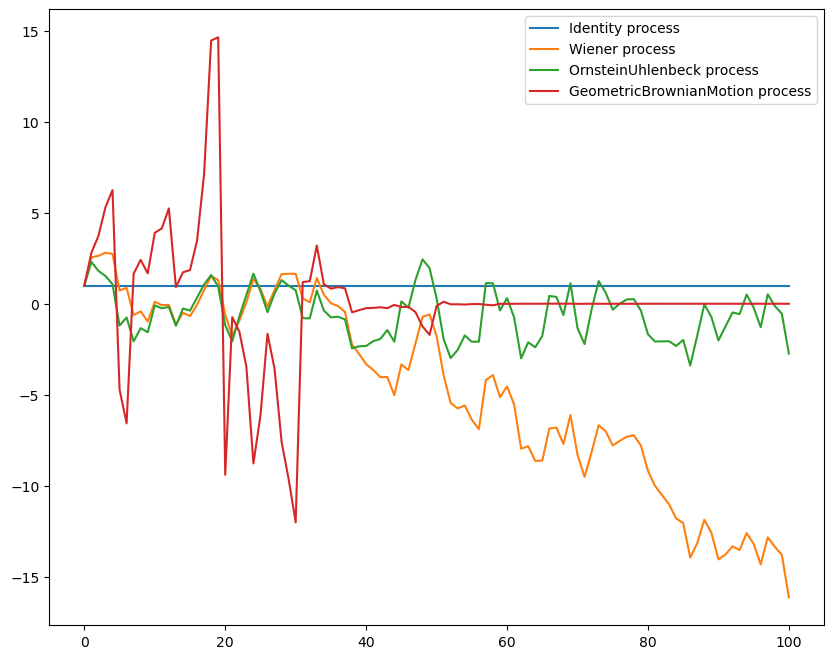

In [181]:
process_names = ["Identity", "Wiener", "OrnsteinUhlenbeck", "GeometricBrownianMotion"]

plt.figure(figsize=(10, 8))
for process_name in process_names:
    process = eval(process_name + "Process")(1.0, store_history=True, random_state=14)
    process.run_process(100)
    plt.plot(process.history)


plt.legend([process_name + " process" for process_name in process_names])


Text(0.5, 1.0, 'Ornstein-Uhlenbeck Process')

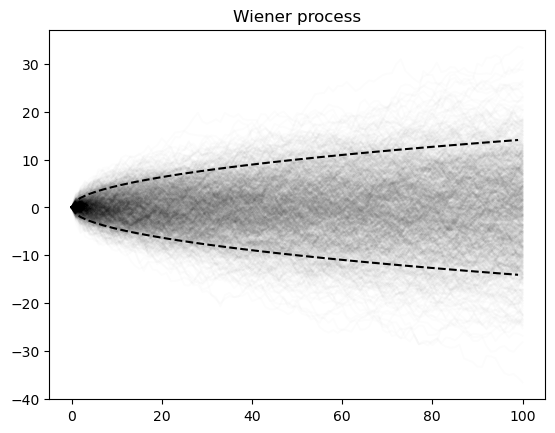

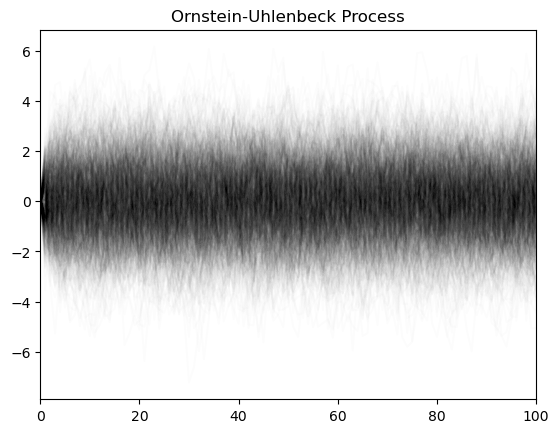

In [174]:
plt.figure()
for i in range(1000):
    process = WienerProcess(0.0, store_history=True)
    process.run_process(100)
    plt.plot(process.history, color="black", alpha=0.01)

plt.plot(np.arange(0, 100), np.sqrt(2 * np.arange(0, 100)), color="black", linestyle="--")
plt.plot(np.arange(0, 100), -np.sqrt(2 * np.arange(0, 100)), color="black", linestyle="--")
plt.title("Wiener process")



plt.figure()
for i in range(1000):
    process = OrnsteinUhlenbeckProcess(0.0, store_history=True)
    process.run_process(100)
    plt.plot(process.history, color="black", alpha=0.01)
plt.xlim([0, 100])
plt.title("Ornstein-Uhlenbeck Process")

## Multiple Inheritance

+ Python objects can inherit from multiple base classes
+ The method resolution order (MRO) defines the order in which Python looks for a method in a hierarchy of classes
+ Daughter class methods take precendence over parent class methods. That's why we were able to override the empty `step` method in our `StochasticProcess` class
+ However, if two parent classes have the same method, the *first* one listed in the class definition will take precedence

```python
class A:
    def foo(self):
        print("A")

class B(A):
    def foo(self):
        print("B")

class C(A):
    def foo(self):
        print("C")

class D(B, C):

    def bar(self):
        self.foo()

d = D()
d.bar() # prints "B"

```


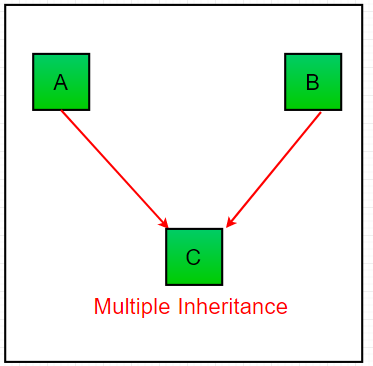

In [182]:
Image("../resources/multiple_inheritance.png")
# Source: https://www.geeksforgeeks.org/types-of-inheritance-python/

Text(0, 0.5, 'Position')

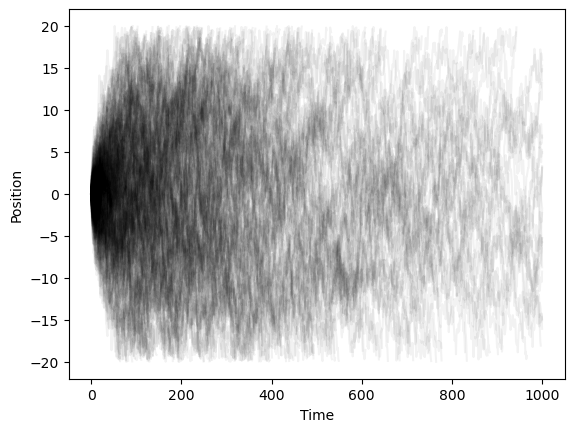

In [185]:
class HaltingProcess:
    """
    A base class for halting processes.
    
    Parameters
        threshold (float): The threshold at which the process halts
    """
    def __init__(self, threshold):
        self.threshold = threshold
        self.store_history = True

    def step(self):
        """
        Subclasses or sibling classes should implement this method
        """
        raise NotImplementedError

    def run_halting_process(self, max_iter=1000):
        """
        Run a halting process, which is a stochastic process that halts when a threshold 
            is reached. If the threshold is not reached after max_iter, then the process
            is halted and the last value is returned.
        """
        np.random.seed(self.random_state)
        for i in range(max_iter):
            self.state = self.step()

            if np.abs(self.state) > self.threshold:
                self.halt_time = i
                break
                # The break statement exits the for loop and stops the simulation
                # before max_iter is reached

            if self.store_history:
                self.history.append(self.state)

        return self.state


class BrownianHaltingProcess(WienerProcess, HaltingProcess):
    # The order matters here

    def __init__(self, start_val, threshold, **kwargs):
        HaltingProcess.__init__(self, threshold)
        WienerProcess.__init__(self, start_val, **kwargs)
        # The order does not matter here
        


plt.figure()
for i in range(300):
    model = BrownianHaltingProcess(0.0, 20.0, store_history=True)
    model.run_halting_process()
    plt.plot(model.history, color="black", alpha=0.05)
plt.xlabel("Time")
plt.ylabel("Position")


# Some other useful built-ins for iterables

+ zip and enumerate are not strictly necessary (there are other ways to do the same thing), but they can make our syntax a bit cleaner and more concise. Functions like this are sometimes called "syntactic sugar"


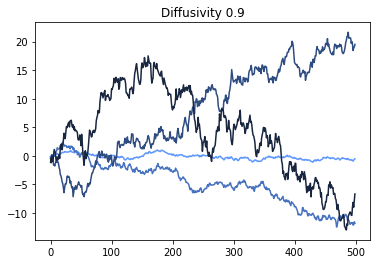

In [266]:
# enumerate provies a tuple of index and value
diffusivities = [0.1, 0.3, 0.6, 0.9]

weiner_process = lambda n, signma: np.cumsum(np.random.normal(0, signma, n))
blue = np.array([0.372549, 0.596078, 1])
for i, sigma in enumerate(diffusivities):
    plt.plot(weiner_process(500, sigma), color=blue * (1 - i / len(diffusivities)))
    plt.title(f"Diffusivity {sigma}")

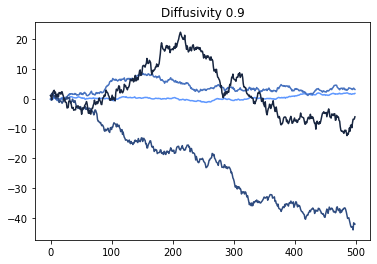

In [268]:
# zip pairs values together
diffusivities = [0.1, 0.3, 0.6, 0.9]

weiner_process = lambda n, signma: np.cumsum(np.random.normal(0, signma, n))
colors = np.array([0.372549, 0.596078, 1]) * (1 - np.arange(0, 1, 0.25)[:, None])
for color, sigma in zip(colors, diffusivities):
    plt.plot(weiner_process(500, sigma), color=color)
    plt.title(f"Diffusivity {sigma}")

## Generators

+ Generators are functions with an internal "state" that serves as a memory
+ Conceptually, they are intermediate between functions and custom objects
+ Generators can be useful when you don't want to store an entire array in memory

In [275]:
def weiner_process(x, max_iter=1000):
    for i in range(100):
        yield x + np.random.normal(0, 1)

# next causes the generator to run until the next yield
process = weiner_process(0)
for i in range(50):
    print(next(process))

1.0854339875048087
-0.6306183121546539
0.9046260382688128
0.4531820617324658
-0.808476394605633
1.69813707350036
-0.10889468951915561
1.0816503069553836
-0.1641697658804684
0.795190707193173
-0.18117155341567806
-0.7035671068914807
-0.6624125941040329
0.5194670301325016
-0.3511876840742135
0.06445341007679474
0.37431047176675003
0.42585851113957124
-1.311510103653711
1.5641783227645105
-1.176658205416261
0.34262199798818915
-0.774959555130414
-0.2715825094720521
1.214601945735314
-0.7222569014213631
-0.8546904440046476
-0.9168290022656728
-0.07579583991808671
0.23941496713527616
0.5716049995967908
1.055681395211403
-0.9960892501233416
-0.9285135134667982
-0.09443114930837106
0.5521484843603496
-0.4906146632116013
1.2265268595914947
0.4149570807168994
0.24271138175203935
1.038543411525472
-0.510328503006917
0.3017768688418901
-0.9317098990910221
-0.07572284741010381
1.2147836628686492
-0.4252776378137409
1.0218920667928268
0.5696565866149781
-0.5982680493769834
